## SVM and Logistic Regression Modeling

#### Introduction
We begin where we left off in the first lab with the reduced training dataset consisting of all user sessions that were booked for the top five hotel clusters representing 410,059 records. We have already utilized the dates in the dataset to create two new continuous feature, booking window (checkin date - day of search) and length of stay (checkout date - checkin date). The raw dates have been dropped now that we have contextualized them into continuous features. We revisited the imputation of the orig_destination_distance (distance from the user's search location to the hotel being searched) and have recalculated it based on the original groupings we intended (posa_continent, hotel_continent, hotel_country).

We are building logistic regression and SVM models to try to classify a training and test data set on an 80/20 split to compare their classification accuracies. Logistic regression weights and support vectors will also be analyzed to begin the process of feature selection and possible dimensionality reduction.

#### Sources:
We make extensive use of the code provided for the LR/SVM unit for the class and code from Sebastian Raschka book "Python Machine Learning"

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reduced, imputed, file.
# Data can be downloaded here: https://www.dropbox.com/s/2vcqmorh3n3cm21/train_booked_top5_imputed.csv?dl=0
train_booked_df = pd.read_csv('data/train_booked_top5_imputed.csv')
train_booked_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
# All features are non-null:
train_booked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 26 columns):
hotel_cluster                409662 non-null int64
site_name                    409662 non-null int64
posa_continent               409662 non-null int64
user_location_country        409662 non-null int64
user_location_region         409662 non-null int64
user_location_city           409662 non-null int64
user_id                      409662 non-null int64
is_mobile                    409662 non-null int64
is_package                   409662 non-null int64
channel                      409662 non-null int64
srch_destination_id          409662 non-null int64
srch_destination_type_id     409662 non-null int64
is_booking                   409662 non-null int64
hotel_continent              409662 non-null int64
hotel_country                409662 non-null int64
hotel_market                 409662 non-null int64
ci_week                      409662 non-null int64
srch_week             

#### Creating model looping structures:
We want to create a predefined number of iteratable train and test data sets for our models. We will be experimenting with different model parameters so will iterate through 6 rounds of train/test data to get an idea about whether tweaks work better than others. Test size is set to 0.2 for our 80/20 split and the random_state is set to 'None' to ensure that we get new samples in each iteration.

In [4]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 6
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(409662, n_iter=6, test_size=0.2, random_state=None)


#### Logistic regression modeling:

The following code allows us to iterate through the previously split test/train data and try different logistic regression parameter tweaks to see which arrives at the best classification accuracy. We made a slight change to the code provided in the class documents to implement the standardization of the test/train features for each iteration. This is more efficient and ensures that the standardization is applied to each unique instance of the test/train splits. We've also created an array that holds different variations of the logistic regression model to easily compare classification accuracies between parameters. We primarily want to see if lowering or raising the error penalties (parameter C) has an influence on accuracy, as well as differences between regularization penalties l2 and l1. The code can be rerun to try difference combinations of parameters by uncommenting below and ensuring that the num_cv_iterations is equal to the lr[] array objects within.

In [5]:
# We've combined the standardization process into each iteration of the loop:

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# Uncomment the following code blocks to try different variations of logistic Regression models

# There isn't much change in the training or test accuracy when different values of C are attempted. For this reason we'll stick
# with C=0.05.
# lr= [LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.1, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.5, class_weight=None),
#      LogisticRegression(penalty='l2', C=1, class_weight=None),
#      LogisticRegression(penalty='l2', C=10, class_weight=None),
#      LogisticRegression(penalty='l2', C=100, class_weight=None)]

# Class weights set to None outperform 'balanced'
# lr= [LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.05, class_weight='balanced'),
#      LogisticRegression(penalty='l2', C=0.05, class_weight='balanced'),
#      LogisticRegression(penalty='l2', C=0.05, class_weight='balanced')]

# There is no improvement when the penalty term is switched to L1 even when the C parameter is adjusted to try different error 
# penalty thresholds. Due to the increased processing time for 'l1' we'll stick with 'l2'
# lr= [LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l2', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l1', C=0.05, class_weight=None),
#      LogisticRegression(penalty='l1', C=0.1, class_weight=None),
#      LogisticRegression(penalty='l1', C=0.5, class_weight=None)]

#Finally we added a 'newton-cg' solver parameter which did not converge, and the 'lbfgs' which didn't seem to hurt.
lr= [LogisticRegression(penalty='l2', C=0.05, class_weight=None), 
     LogisticRegression(penalty='l2', C=0.05, class_weight=None),
     LogisticRegression(penalty='l2', C=0.05, class_weight=None), 
     LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs'),
     LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs'), 
     LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs')]

stdsc = StandardScaler()

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    X_train_std = stdsc.fit_transform(X[train_indices])
    X_test_std = stdsc.transform(X[test_indices])
    
    lr[iter_num].fit(X_train_std, y[train_indices]) # train object
    y_hat = lr[iter_num].predict(X_test_std) # get test set precitions
    
  
    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print('Training accuracy:', lr[iter_num].score(X_train_std, y[train_indices]))
    print('Test accuracy:', lr[iter_num].score(X_test_std, y[test_indices])) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)
    print

====Iteration 0  ====
('Training accuracy:', 0.36383414345389026)
('Test accuracy:', 0.36637252389147229)
confusion matrix
[[ 1170   274    16  2240  9020]
 [  822   256    29  1345 12098]
 [  673   183    68  1396 14718]
 [  478   314   118  6210  6224]
 [  981   172    38   776 22314]]

====Iteration 1  ====
('Training accuracy:', 0.36414842751175514)
('Test accuracy:', 0.36556698766064954)
confusion matrix
[[ 1178   261    21  2289  9056]
 [  776   238    43  1305 12231]
 [  691   171    63  1342 14769]
 [  523   326   109  6201  6106]
 [  988   123    38   813 22272]]

====Iteration 2  ====
('Training accuracy:', 0.36415453011482046)
('Test accuracy:', 0.36573785898233924)
confusion matrix
[[ 1139   217    27  2313  9027]
 [  879   222    42  1315 12072]
 [  663   138    59  1420 14812]
 [  565   299   114  6103  6158]
 [  961   138    48   759 22443]]

====Iteration 3  ====
('Training accuracy:', 0.36393178510293567)
('Test accuracy:', 0.3652618603004894)
confusion matrix
[[ 1221 

#### Logistic regression conclusions:
Throughout all our parameter explorations we arrived at the LR model: LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs') which did not perform particularly well. Test accuracy hovered around 36% through the majority of the parameter settings and iterations. Knowing that SVM doesn't typically stray too far from the results of logistic regression, this first model doesn't provide a good indicatation that classification will be easily determined from these features.

#### Stochastic Gradient Descent modeling:
We initially tried to model our data in sklearn.svm but the size didn't allow it. However, using the SGDClassifier class we can model a stochastic gradient descent version to more efficiently make use of SVM. The code below iterates over the SVM model in the same way as LR.

In [6]:
# We've combined the standardization process into each iteration of the loop:

from sklearn.linear_model import SGDClassifier

# Uncomment the following code blocks to try different variations of logistic Regression models

# First pass shows a lot more variabilty in the accuracy results between iterations ranging from 24% to 31%. None of 
# these models beats LR at this point.
# svm_sgd= [SGDClassifier(loss='hinge', penalty='l2', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5)]

# Second pass seems to show that the 'elasticnet' penalty parameter might perform better.
# svm_sgd= [SGDClassifier(loss='hinge', penalty='l2', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='l2', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='l1', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='l1', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5)]

# Third pass confirms that elasticnet produces better accuracy more often, but is still prone to swings.
# svm_sgd= [SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5), 
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5)]

# Increasing the number of iterations produced the only result comparable to LR, but this is at the expense
# of performance. More iterations did produce a 36% accuracy result (n_iter-25), but didn't necessarily guarantee
# better results as 100 iterations brought the accuracy back down to 26%. This doesn't seem like a viable alternative
# to LR.
# svm_sgd= [SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=5),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=25), 
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=50),
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=100), 
#          SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=500)]

svm_sgd= [SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10),
         SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10),
         SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10), 
         SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10),
         SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10), 
         SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10)]


stdsc = StandardScaler()

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    X_train_std = stdsc.fit_transform(X[train_indices])
    X_test_std = stdsc.transform(X[test_indices])
    
    svm_sgd[iter_num].fit(X_train_std, y[train_indices]) # train object
    y_hat = svm_sgd[iter_num].predict(X_test_std) # get test set precitions
    
  
    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print('Training accuracy:', svm_sgd[iter_num].score(X_train_std, y[train_indices]))
    print('Test accuracy:', svm_sgd[iter_num].score(X_test_std, y[test_indices])) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)
    print

====Iteration 0  ====
('Training accuracy:', 0.34725337092536823)
('Test accuracy:', 0.35230005004088705)
confusion matrix
[[  494  1113   539  2969  7748]
 [  362  1083   326  2096 10640]
 [  314  1151   341  2241 12926]
 [  194   534   200  7267  5125]
 [  470  1569   460  2091 19680]]

====Iteration 1  ====
('Training accuracy:', 0.35374043798382199)
('Test accuracy:', 0.35337409834865074)
confusion matrix
[[ 1566     1   137  3090  7904]
 [ 1301     1   110  2098 11177]
 [ 1241     2   120  2246 13457]
 [  902     2    78  7157  5276]
 [ 1717     4   106  2131 20109]]

====Iteration 2  ====
('Training accuracy:', 0.30400117169978852)
('Test accuracy:', 0.30318675014951241)
confusion matrix
[[ 2334  2384     0  2239  5725]
 [ 2888  2856     0  1322  7511]
 [ 3507  2857     0  1352  9446]
 [ 1583  1098     0  6536  4036]
 [ 5315  5097     0   732 13115]]

====Iteration 3  ====
('Training accuracy:', 0.27407400626737333)
('Test accuracy:', 0.2774950264240294)
confusion matrix
[[ 2630 

#### SGD Conclusions:
There is less consistency in SGD models. We saw accuracy results typically in the 29-33% range but also dip to 22% and reach 36% on the high end. We arrived at a final model: SGDClassifier(loss='hinge', penalty='elasticnet', n_iter=10) which maintained decent performance and still was able to hit 35-36% accuracy in line with what we saw with LR.

#### Support Vector Machine Modeling
We've seen sporadic but relatively similiar results using SGD when compared to LR. Now we will take a final look at a true support vector machine model as a last check of our classification strategies. Do to the extra processing requirements for SVM models, we will not be iterating through the model as we've done with LR and SGD. We are also using a random sample of 10,000 instances from the training split to train the model. Anything higher than this becomes too computationally expensive.


In [5]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2)

# train the model just as before
svm = SVC(C=0.05, kernel='linear', degree=5, gamma='auto') # get object
x_rindex = np.random.choice(len(X_train),10000,replace=False) 
svm.fit(stdsc.fit_transform(X_train[x_rindex]), y_train[x_rindex])  # train object

y_hat = svm.predict(stdsc.transform(X_test)) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print ('accuracy:', acc) 
print (conf)

('accuracy:', 0.36251571405904826)
[[ 1947    18    23  2061  8667]
 [ 1429    30    69  1118 12070]
 [ 1249    24    82  1146 14562]
 [ 1117    99   185  5824  6139]
 [ 1655     3    44   553 21819]]


#### SVM Conclusions
Running this code several times on a variety of parameters (C = 0.05, 0.1, 1.0), (kernel = 'linear', 'rbf'), (sample size = 1,000-10,000) all yield accuracy results in the 35-36% range, very closely alligned with the Logistic Regression model. We found that while sample sizes in the 4,000-7,000 range can still yield accuracy greater than 35%, it's not until the training sample reaches 10,000 that consistent 36% accuracy in line with the logistic regression model can be acheived.

#### Model comparisons
Unfortunately all of the models share the problematic characteristic that none of them do a good job predicting our 5 classes. While all models allowed us to hit around the 35-36% accuracy range at one point, the Logistic Regression model did so in the most computationally efficient and consistent manner. 

##### Converge times:

Logistic Regression Model: (Mean converge time on 6 iterations = 8 seconds, median converge time roughly = 10 seconds)

Stochastic Gradient Descent Model: (Mean converge time on 6 iterations = 7.5 seconds, median converge time roughly = 7.5 seconds)

Support Vector Machines Model: (Mean converge time on 6 iteration at n(10,000) = 32 seconds, n(5,000) = 15 seconds, n(4,000) = 12 seconds)

The SGD model was far more inconsistent in classifying results accurately. Increasing the number of iterations didn't seem to help the inconsistency but did greatly decrease performance, therefore paying a high cost for no gain.

The SVM model matched the LR model in terms of accuracy and consistency, but took four times longer to acheive similar results. 

Final conclusion: Despite the poor showing of all models, logistic regression wins in terms of consistency and computational efficiency.

#### Logistic Regression Weights
Having arrived at models that function well for both LR and SVM despite their poor classification, we will now create a new test/train split with random_state=0 so we can consistently interpret weights and support vectors for the remainder of the lab. 

In [8]:
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
#    X_train , y_train , X_test, y_test (they were set in a for loop above)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=0)

# scale attributes by the training set
stdsc.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_std = stdsc.transform(X_train) # apply to training
X_test_std = stdsc.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr.fit(X_train_std,y_train)  # train object

y_hat = lr.predict(X_test_std) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print 'accuracy:', acc 
print conf
print 
print 'The classes are hotel cluster numbers:', lr.classes_
print

# sort these attributes and spit them out
zip_vars = zip(lr.coef_.T,train_booked_df.columns) # combine attributes
# zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef # now print them out


accuracy: 0.362515714059
[[ 1145   271    16  2285  9215]
 [  789   232    37  1314 12285]
 [  690   158    58  1328 14884]
 [  492   319   103  6121  6140]
 [  967   127    33   778 22146]]

The classes are hotel cluster numbers: [28 42 48 59 91]

hotel_cluster has weight of [ 0.04211418 -0.03677282 -0.0055645   0.0506373  -0.05870071]
site_name has weight of [ 0.0338822  -0.04008045 -0.08140573  0.00549596 -0.06829799]
posa_continent has weight of [ 0.02018174  0.02786913  0.01093151 -0.01581407  0.02324778]
user_location_country has weight of [-0.01653654  0.01665659 -0.04734268  0.05816947 -0.02784848]
user_location_region has weight of [-0.00095428 -0.00617783 -0.00189959 -0.00849104  0.0147713 ]
user_location_city has weight of [-0.01342082  0.00842542 -0.00253428  0.0185668  -0.00765681]
user_id has weight of [  7.65215533e-03  -9.38880913e-05  -1.60751012e-02   2.59003759e-02
  -1.10710693e-02]
is_mobile has weight of [ 0.01107021 -0.05125481 -0.05589401  0.16144374 -0.02957094

#### Weight interpretation
We can see from the output that each feature's weights consists of a five 1x5 vector with each value representing the weight for each class 28, 42, 48, 59 & 91. The size of the weights needs visualization to properly interpret:

This chart represents feature weights for hotel cluster 28 :


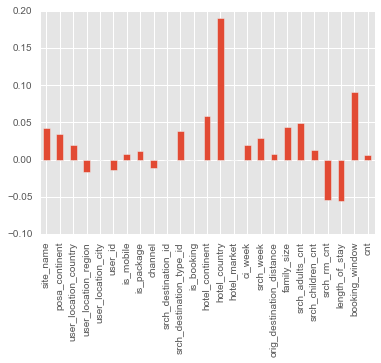

This chart represents feature weights for hotel cluster 42 :


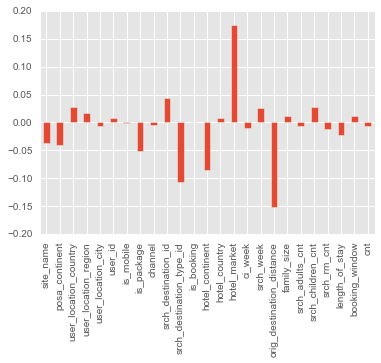

This chart represents feature weights for hotel cluster 48 :


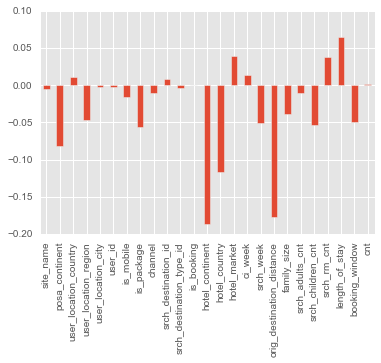

This chart represents feature weights for hotel cluster 59 :


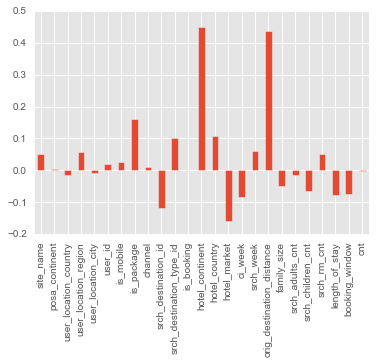

This chart represents feature weights for hotel cluster 91 :


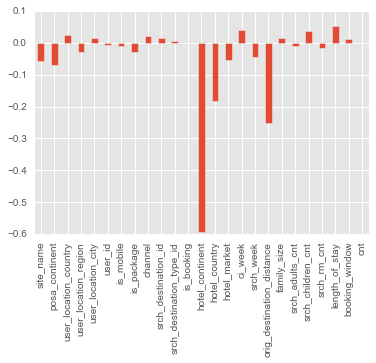

In [9]:
# now let's make a pandas Series with the names and values, and plot them
plt.style.use('ggplot')

variable_names = train_booked_df.columns
variable_names = variable_names[1:]

for chart in range(0, len(lr.coef_)):
    print '=============================================================='
    print 'This chart represents feature weights for hotel cluster',lr.classes_[chart],':'
    lr.coef_[chart]
    weights = pd.Series(lr.coef_[chart],variable_names)
    weights.plot(kind='bar')
    plt.show()

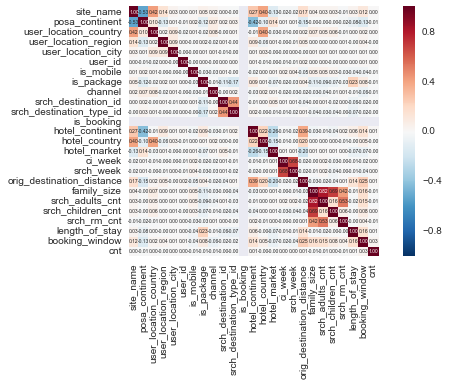

In [10]:
cm = np.corrcoef(train_booked_df[variable_names].values.T)
sns.set()
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 5},
            yticklabels=variable_names,
            xticklabels=variable_names)

plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

After standardizing the data we can begin to see the variables that have the highest weights. Those with the highest weights indicates feature importance or in other words have more of an impact on the final model.

The three variables that had the highest weights across classes all pertain to hotel geography (continent, country & market). These features also happen to be descriptive elements of the hotel cluster so it makes sense that they would have feature importance. The masked varible hotel cluster in which we are trying to predict is made up of the hotel location as well as price and rating. The hotel country, continent and market will not give us the exact location of the hotels but they will allow us to make grouping of these varibles that might eventually predict the model.

The only other feature that is consistently weighted highly across classes is orig_destination_distance which measures the distance from the user's search location to the hotel location. Perhaps this distance combined with the geographic location weights and effectively narrows down the hotel cluster options.

Classes 28 and 48 have heavier weights on the booking window and length of stay features, attributes we added thinking that these continuous variables would be beneficial to classification. It seems strange that these would be influential on only a couple clusters. Maybe resort or exotic locations where longer stays and booking windows are more common are only good at classifying these select clusters. If classes 42, 59 and 91 are your run-of-the-mill cities or trafficked heavily by business travelers where 1-3 night stays booked less than a month out are most common, these features might have less explanatory power and therefore lower weights. It is also interesting that for classes 28 and 48 the family count, adult count, number of rooms, and specific week during the year all see spikes (on one of the two classes) in their weights. This adds to the story that these might be vacation destinations where these hotel attributes are more important.

While the weights may provide some insight into the characteristics of certain hotel clusters, the fact remains that the classification accuracy is still quite low, and they are not doing a good enough job for our model to be predictive.


#### Support vectors:
Having explored the logistic regression model weights, let's turn to the SVM model to see if we can gain some insights into our classes by examining the support vectors themselves.

In [6]:
# train the model on the new test/train dataset
svm = SVC(C=0.05, kernel='linear', degree=5, gamma='auto') # get object
x_rindex = np.random.choice(len(X_train),10000,replace=False) 
svm.fit(stdsc.fit_transform(X_train[x_rindex]), y_train[x_rindex])  # train object

# look at the support vectors
print (svm.support_vectors_.shape)
print (svm.support_.shape)
print (svm.n_support_ )

(9336, 25)
(9336,)
[1535 1730 2055 1282 2734]


In [7]:
# sv = pd.support_vectors_
df_tested_on = train_booked_df.iloc[x_rindex]
df_support = df_tested_on.iloc[svm.support_,:]

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9336 entries, 133085 to 320482
Data columns (total 26 columns):
hotel_cluster                9336 non-null int64
site_name                    9336 non-null int64
posa_continent               9336 non-null int64
user_location_country        9336 non-null int64
user_location_region         9336 non-null int64
user_location_city           9336 non-null int64
user_id                      9336 non-null int64
is_mobile                    9336 non-null int64
is_package                   9336 non-null int64
channel                      9336 non-null int64
srch_destination_id          9336 non-null int64
srch_destination_type_id     9336 non-null int64
is_booking                   9336 non-null int64
hotel_continent              9336 non-null int64
hotel_country                9336 non-null int64
hotel_market                 9336 non-null int64
ci_week                      9336 non-null int64
srch_week                    9336 non-null int64
orig

In [ ]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['hotel_cluster'])
df_grouped = train_booked_df.groupby(['hotel_cluster'])

# plot KDE of Different variables
vars_to_plot = ['orig_destination_distance','length_of_stay','booking_window','family_size']

for v in vars_to_plot:
    plt.figure(figsize=(15,6))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Cluster 28','Cluster 42','Cluster 48','Cluster 59','Cluster 91'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Cluster 28','Cluster 42','Cluster 48','Cluster 59','Cluster 91'])
    plt.title(v+' (Original)')

(We need to update this interpretation.)

In the case of SVM, we are creating a plane to separate each class from the rest of the classes.  For each class there are two vectors to define the plane. For all classes the hotel_continent plays a significent role in one of the vectors defining the plane that divides the class from the rest of the classes.  Hotel_country is the next major componet of the vectors defining the plane that divides the class from the rest of the classes for four of the classes. This is consistent with what we've already seen in the logistic regression weights.

#### Conclusion
We have implemented and experimented with a variety of models to make our first attempt at classifying hotel clusters based on 25 features. We have also examined the weights and vectors that make up underlying logic of these models. Unfortunately, our initial results are not positive with only around a third of test samples being classified accurately. We have a sense that the hotel's geographic features and distances between hotel and the user initiating the search are of importance in the model for all classes. But from there different features have importance to different sub-classes or even individual classes. Our next steps should include more formalized feature selection to try to shed some of the features that aren't telling us anything, and perhaps enlist other kinds of dimensionality reduction to see if we can improve our classification accuracy.